In [1]:
import matplotlib.pyplot as plt
import torch

from cheetah import ParticleBeam, Quadrupole, Segment
from cheetah.utils.bmadx import bmad_to_cheetah_coords, cheetah_to_bmad_coords

torch.set_printoptions(precision=15, sci_mode=True)

In [2]:
# Incoming beam
coords = torch.ones((1, 10000, 7))
coords[..., :-1] = torch.randn((1, 10000, 6)) * 1e-3
coords[..., 5] *= 1e2
energy = torch.tensor([1e7])
incoming_beam = ParticleBeam(particles=coords, energy=energy, dtype=torch.float64)
print(f"particles shape: {incoming_beam.particles.shape}")
print(f"energy shape: {incoming_beam.energy.shape}")

particles shape: torch.Size([1, 10000, 7])
energy shape: torch.Size([1])


In [3]:
# Test if coordinate transormation is correct
from scipy.constants import physical_constants

mc2 = torch.tensor(
    physical_constants["electron mass energy equivalent in MeV"][0] * 1e6,
    dtype=torch.float64,
)
bmad_coords, p0c = cheetah_to_bmad_coords(
    incoming_beam.particles, incoming_beam.energy, mc2
)
test_coords, test_ref_energy = bmad_to_cheetah_coords(bmad_coords, p0c, mc2)
print(torch.allclose(incoming_beam.energy, test_ref_energy, atol=0, rtol=1e-14))
print(torch.allclose(incoming_beam.particles, test_coords, atol=1e-14, rtol=1e-14))

True
True


In [4]:
# Quadrupole parameters
l_quad = torch.tensor([1.0])
k1_quad = torch.tensor([10.0])
tilt = torch.tensor([0.5])
offsets = torch.tensor([0.01, -0.02])

# Default tracking method
cheetah_quad_default = Quadrupole(
    l_quad, k1_quad, misalignment=offsets, tilt=tilt, dtype=torch.double
)
cheetah_segment_default = Segment(elements=[cheetah_quad_default])
cheetah_default_outgoing_beam = cheetah_segment_default.track(incoming_beam)

# Bmad-X tracking method
cheetah_quad_bmadx = Quadrupole(
    l_quad,
    k1_quad,
    misalignment=offsets,
    tilt=tilt,
    num_steps=10,
    tracking_method="bmadx",
    dtype=torch.double,
)
cheetah_segment_bmadx = Segment(elements=[cheetah_quad_bmadx])
cheetah_bmadx_outgoing_beam = cheetah_segment_bmadx.track(incoming_beam)

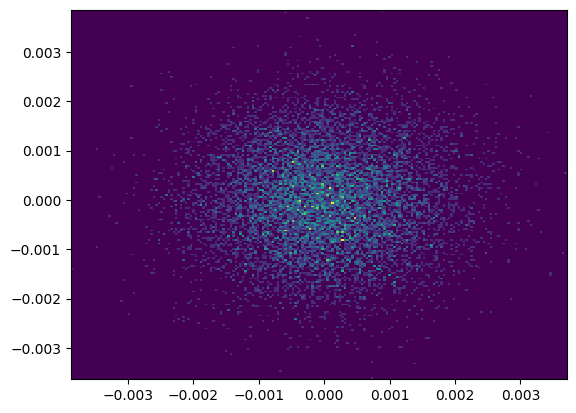

In [5]:
# Initial y-py phase space
plt.hist2d(incoming_beam.particles[0, :, 2], incoming_beam.particles[0, :, 3], bins=200)
plt.show()

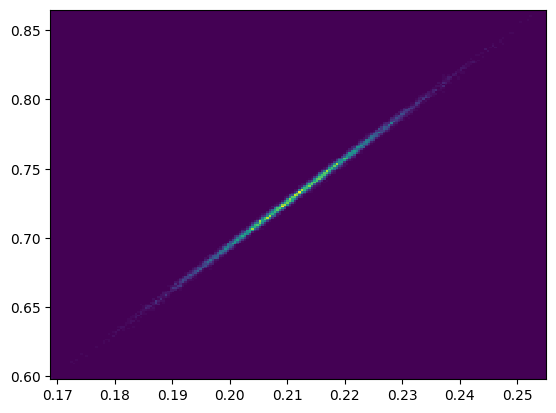

In [6]:
# Cheetah tracking method output y-py phase space: no chromatic aberration
plt.hist2d(
    cheetah_default_outgoing_beam.particles[0, :, 2],
    cheetah_default_outgoing_beam.particles[0, :, 3],
    bins=200,
)
plt.show()

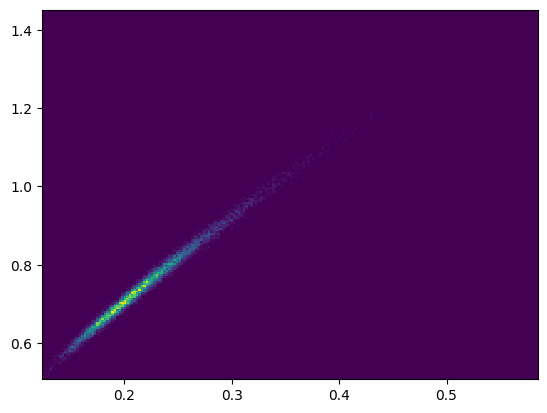

In [7]:
# Bmad-X tracking method output y-py phase space: chromatic effects:
plt.hist2d(
    cheetah_bmadx_outgoing_beam.particles[0, :, 2],
    cheetah_bmadx_outgoing_beam.particles[0, :, 3],
    bins=200,
)
plt.show()

In [8]:
# Compare against Bmad-X package
from bmadx.bmad_torch.track_torch import Beam, TorchQuadrupole, TorchLattice

bmadx_beam = Beam(data=bmad_coords, p0c=p0c, mc2=mc2)
bmadx_quad = TorchQuadrupole(
    L=l_quad,
    K1=k1_quad,
    X_OFFSET=offsets[0],
    Y_OFFSET=offsets[1],
    TILT=tilt,
    NUM_STEPS=10,
)
bmadx_lattice = TorchLattice([bmadx_quad])
bmadx_out_coords = torch.stack(bmadx_lattice(bmadx_beam)[:6], dim=-1)
bmadx_out_with_cheetah_coords, ref_energy = bmad_to_cheetah_coords(
    bmadx_out_coords, p0c, mc2
)

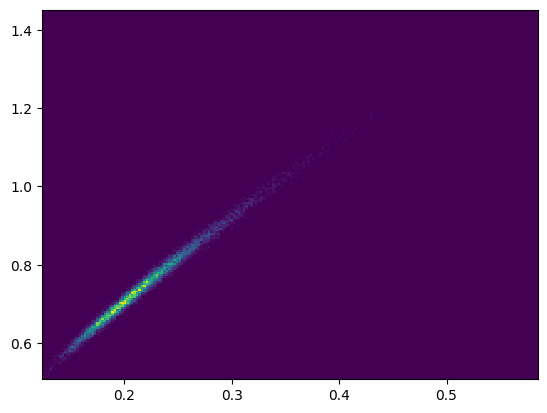

In [9]:
# Bmad-X package tracking output y-py phase space: chromatic effects:
plt.hist2d(
    bmadx_out_with_cheetah_coords[0, :, 2],
    bmadx_out_with_cheetah_coords[0, :, 3],
    bins=200,
)
plt.show()

In [10]:
# Compare against cheetah with Bmad-X tracking method (expected to be the same)
print(
    torch.allclose(
        bmadx_out_with_cheetah_coords,
        cheetah_bmadx_outgoing_beam.particles,
        atol=1e-7,
        rtol=1e-7,
    )
)
# For some reason, Bmad-X results only agree to single precision.

True


In [11]:
# Compare against cheetah with default tracking method (expected to be significantly
# different)
print(
    torch.allclose(
        bmadx_out_with_cheetah_coords,
        cheetah_default_outgoing_beam.particles,
        atol=1e-2,
        rtol=1e-1,
    )
)

False


In [12]:
# Save tensors for tests
# torch.save(incoming_beam, "incoming_beam.pt")
# torch.save(bmadx_out_with_cheetah_coords, "bmadx_out_with_cheetah_coords.pt")